In [1]:
from utils import *
from modules import *
import numpy as np 
import pandas as pd
from PIL import Image
import os
from os import listdir
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score,adjusted_rand_score
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time

import pickle as pkl

import warnings
warnings.filterwarnings("ignore")

# Fonctions

In [2]:
def evaluation(datas,labels,verbose=False):
    titles = ["X","Representation Latente","X_hat"]
    scores = []
    puritities = []
    rand_scores= []
    for i,data in enumerate(datas):

        shape = data.shape[1]
        nb_classes = len(np.unique(labels))

        neuro_i_1 = shape
        neuro_o_1 = shape // 2
        neuro_i_2 = shape // 2
        neuro_o_2 = shape // 4
        neuro_i_3 = shape // 4
        neuro_o_3 = nb_classes
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 50


        facteur_norma = 0.8
        lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
        lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
        lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        mseloss = MSELoss()
        CE = CrossEntropieLoss(nb_classes)
        softmax = SoftMax()


        network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,softmax]
        network = Sequentiel(network_layers)

        if verbose : print("Optimisation de : ",titles[i])
        opti = Optim(network,CE,1e-2)
        opti.SGD(data,labels,batch_size,epochs)

        score = opti.getNetwork().accuracy(data,labels) 
        scores.append(score)
        if verbose : print("Accuracy sur les images issues de l'auto encodeur",score)    
        
        kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(data)
        yhat = kmeans.labels_
        
        
        y_cluster_pred = np.zeros(len(data))
        indices = np.arange(len(data))

        for cluster in range(3):

            vals, counts = np.unique(labels[yhat == cluster], return_counts=True)
            val_maj = vals[np.argmax(counts)]

            y_cluster_pred[indices[yhat == cluster]] = val_maj
        
        purete = cluster_purity(labels,y_cluster_pred)
        puritities.append(purete)
        
        rs  = rand_score(labels,y_cluster_pred)
        rand_scores.append(rs)
        
        if verbose : 
            print("Pureté du clustering : ",purete)
            print("Rand score  : ",rs)
            print("Adjusted Rand Score : ",adjusted_rand_score(labels,y_cluster_pred))
            print()

        
        
    return scores,puritities,rand_scores
        
        
        
def optimisation_espace_latent(data,labels,dim_espace_latent_list,eps,verbose=False):
    
    nb_classes = len(np.unique(labels))
    n_samples = data.shape[0]
    scores = []
    puritities = []
    rand_scores= []
    
    
    for dim_espace_latent in dim_espace_latent_list:
        

        neuro_i_1 = 256
        neuro_o_1 = 160
        neuro_i_2 = 160
        neuro_o_2 = 120
        neuro_i_3 = 120
        neuro_o_3 = 60
        neuro_i_4 = 60
        neuro_o_4 = dim_espace_latent
        
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 100
        nb_couches = 4


        facteur_norma = 0.8


        lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
        lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
        lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
        lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma)

        lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma)
        lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma)
        lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma)
        lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma)

        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        BCE = BinaryCrossEntropie()


        network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,lineaire_4_enc,TanH,
                          lineaire_4_dec,TanH,lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
        network = Sequentiel(network_layers)

        auto_encodeur_usps = AutoEncodeur(network,BCE)

        
        if verbose : print("Dimension espace latent : ",dim_espace_latent)
        
        auto_encodeur_usps.optimisation(data,labels,batch_size,epochs,eps,False)
        
        
        
        latent_repre = auto_encodeur_usps.encode(data)
        
        datas = [latent_repre]
        score,purete,rand_score = evaluation(datas,labels,verbose)
        scores.append(score)
        puritities.append(purete)
        rand_scores.append(rand_score)
        
    return scores , puritities , rand_scores



def create_auto_encodeur(X_train,output_dim, nb_couche_lin,activations, facteur_norma, plage_biais, batch_size, epochs,eps=1e-4):
    np.random.seed(42)
    input_dim = X_train.shape[1]
    n_samples = X_train.shape[0]
    neuro_in = [input_dim]
    neuro_out = []
    activations_enc = activations[0]
    activations_dec = activations[1]
    assert len(activations_enc) == nb_couche_lin and len(activations_dec) == nb_couche_lin
    for i in range(0,nb_couche_lin) : 
        neuro_out.append(neuro_in[::-1][0] // 2)
        neuro_in.append(neuro_out[::-1][0])
    neuro_out[-1] = output_dim
    neuro_in = neuro_in [:-1]
    modules_enc = []
    for i in range(nb_couche_lin):
        modules_enc.append(ModuleLineaire(neuro_in[i], neuro_out[i], plage_biais, facteur_norma))
        modules_enc.append(activations_enc[i])
        

    modules_dec = []
    #neuro_out = neuro_out[::-1]
    neuro_in = neuro_in[::-1]
    neuro_out = neuro_out[::-1]
    for i in range(nb_couche_lin):
        modules_dec.append(ModuleLineaire(neuro_out[i], neuro_in[i], plage_biais, facteur_norma))
        modules_dec.append(activations_dec[i])
        
    
    network = Sequentiel(modules_enc + modules_dec)
    BCE = BinaryCrossEntropie()
    auto_encodeur_usps = AutoEncodeur(network, BCE)
    auto_encodeur_usps.optimisation(X_train, X_train, batch_size, epochs,eps)
    
    return auto_encodeur_usps




def optimisation_nb_layers(X_train,Y_train,liste_layers,output_dim,facteur_norma,plage_biais,batch_size,epochs,random_activ):
    shape = X_train.shape[1]
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    activ = np.array([TanH,sigmoide])
    scores = []
    act_s = []
    opt_s = []
    
    
  
    for nb_layer in liste_layers:
        print("Optimisation nb_layer  : ",nb_layer)
        
        if random_activ:
            np.random.seed(42)
            activations_enc = np.random.randint(0,2,size=nb_layer)
            activations_dec = np.random.randint(0,2,size=nb_layer)

            activ_enc = activ[activations_enc]
            activ_dec = activ[activations_dec]

            activ_layer = [activ_enc,activ_dec]
        else:
            activations_enc = [TanH for _ in range(nb_layer)]
            activations_dec = [TanH for _ in range(nb_layer - 1)]
            activations_dec.append(sigmoide)
            activ_layer = [activations_enc,activations_dec]
        
        opt = create_auto_encodeur(X_train,output_dim, nb_layer,activ_layer, facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)
        
        latent_repre = opt.encode(X_train)
        X_train_hat = opt.decode(latent_repre)
        
        scores.append(evaluation([X_train_hat],Y_train)[0])
        act_s.append(activ_layer)
        opt_s.append(opt)
        
        
    return scores,act_s,opt_s




def optimisation_network(X_train,Y_train,X_test,Y_test,liste_layers,liste_dim_espace_latent,batch_size,epochs,random_activ=False,verbose=False):
    
    facteur_norma = 0.8
    plage_biais = (0,1)
    resultat_train = {}
    scores_test = []
    for output_dim in liste_dim_espace_latent :
        print("Optimisation de la dimension de l'espace latent : ",output_dim)
        resultat_train["Espace latent " +str(output_dim)] = optimisation_nb_layers(X_train,Y_train,liste_layers,output_dim,facteur_norma,plage_biais,batch_size,epochs,random_activ)
        print()
        l = []
        for i,nb_layer in enumerate(liste_layers):
            opt = resultat_train['Espace latent '+str(output_dim)][2][i]
            latent_repre = opt.encode(X_test)
            X_test_hat = opt.decode(latent_repre)

            l.append(evaluation([X_test_hat],Y_test)[0])
        scores_test.append(l)
    
    LDS = ["LD"+str(output_dim) for output_dim in liste_dim_espace_latent]
    
    if verbose:
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        for i, output_dim in enumerate(liste_dim_espace_latent) :
            
            scores = resultat_train['Espace latent '+str(output_dim)][0]
            plt.title("Accuracy du train selon l'espace latent ")
            plt.xlabel("nombre de layers")
            plt.ylabel("accuracy")
            plt.plot(liste_layers,scores)
        plt.legend(LDS)
        
        
        plt.subplot(1,2,2)
            
        for i, output_dim in enumerate(liste_dim_espace_latent) :

            activs = resultat_train['Espace latent '+str(output_dim)][1]
            plt.title("Accuracy du train selon l'espace latent")
            plt.xlabel("nombre de layers")
            plt.ylabel("accuracy")
            plt.plot(liste_layers,scores_test[i])

        plt.legend(LDS)

        plt.show()
        
        
    maximums = []
    for i, output_dim in enumerate(liste_dim_espace_latent) :
        
        scores , activations ,_ = resultat_train['Espace latent '+str(output_dim)]
        maximums.append(np.max(scores))
        
    
    dim_espace_latent_optimal = liste_dim_espace_latent[np.argmax(maximums)]
    scores = resultat_train['Espace latent '+str(dim_espace_latent_optimal)][0]
    nb_layer_optimal = liste_layers[np.argmax(scores)]
    nb_layer_optimal_ind = np.argmax(scores)
    activ_optimal = resultat_train['Espace latent '+str(dim_espace_latent_optimal)][1][nb_layer_optimal_ind]
    
    network_optimal = create_auto_encodeur(X_train,dim_espace_latent_optimal, nb_layer_optimal,activ_optimal, facteur_norma, plage_biais, batch_size, epochs)
    
    print("Auto encodeur optimal : ")
    print("Nombre layer optimal : ",nb_layer_optimal)
    print("Dimension optimale de l'espace latent : ",dim_espace_latent_optimal)
    print("Fonctions d'activation prises : ")
    print([str(a) for a in activ_optimal[0]])
    print([str(a) for a in activ_optimal[1]])
        
    return network_optimal


# 1. Données USPS

In [3]:
data = pkl.load(open("data/usps.pkl",'rb'))

X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

## Optimisation des hyperparametres de l'auto encodeur

### Fonctions d'activation du reseau d'une maniere aleatoire

Optimisation de la dimension de l'espace latent :  2
Optimisation nb_layer  :  2


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.83it/s]


Optimisation nb_layer  :  3


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.72it/s]


100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.08it/s]


Optimisation de la dimension de l'espace latent :  8
Optimisation nb_layer  :  2


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]


Optimisation nb_layer  :  3


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.69it/s]


100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.21it/s]


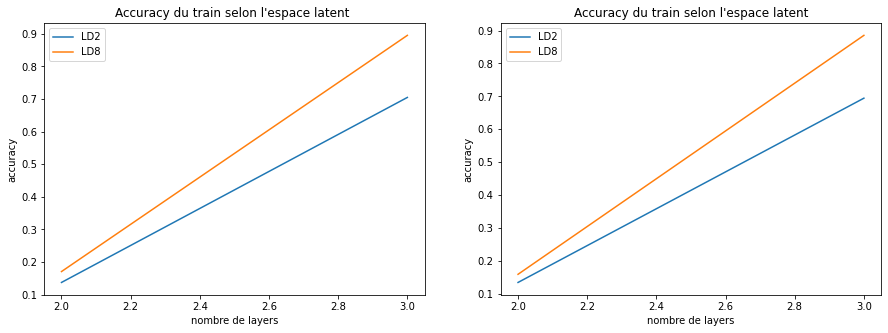

100%|███████████████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]

Auto encodeur optimal : 
Nombre layer optimal :  3
Dimension optimale de l'espace latent :  8
Fonctions d'activation prises : 
['TanH', 'Sigmoid', 'TanH']
['TanH', 'TanH', 'Sigmoid']


In [5]:
liste_layers = np.array([2,3])
liste_dim_espace_latent = np.array([2,8])
batch_size = 50
epochs = 50

auto_encodeur_optimal_rand = optimisation_network(X_train,Y_train,X_test,Y_test,
                                        liste_layers,liste_dim_espace_latent,batch_size,epochs,
                                        random_activ=True,verbose=True)


net_to_graph(auto_encodeur_optimal_rand.network, net_name="networks_images/network_MC_alphabets", horizontal=True)


In [6]:
nb_layer_optimal = len(auto_encodeur_optimal_rand.layers_encodeur) // 2
latent_repre = auto_encodeur_optimal_rand.encode(X_train)
dim_latent_optimale = latent_repre.shape[1]

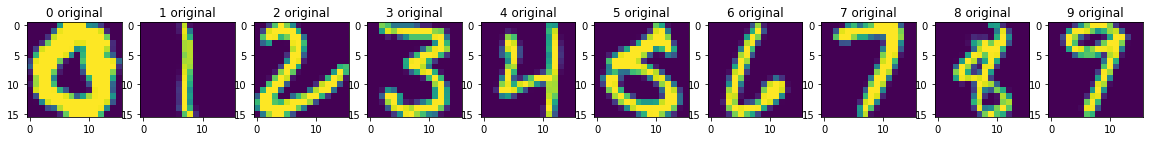

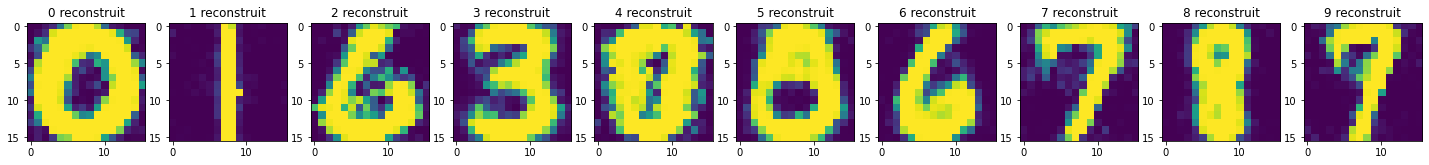

In [11]:
latent_repre = auto_encodeur_optimal_rand.encode(X_train)
X_train_hat = auto_encodeur_optimal_rand.decode(latent_repre)


plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

### Affichage des données USPS train induites de l'espace latent apres une t-SNE

- Train

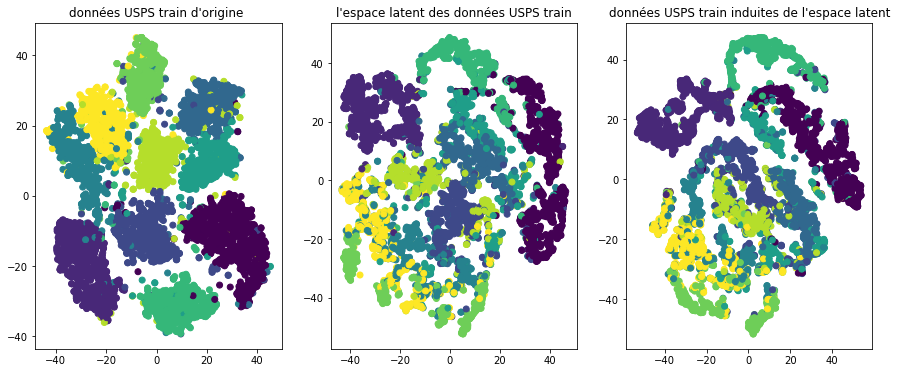

In [12]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


fig = plt.figure(figsize=(15,6))


plt.subplot(131)
repre_2D = tsne.fit_transform(X_train)
plt.title("données USPS train d'origine ")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

plt.subplot(132)
repre_2D = tsne.fit_transform(latent_repre)
plt.title("l'espace latent des données USPS train")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

plt.subplot(133)
repre_2D = tsne.fit_transform(X_train_hat)
plt.title("données USPS train induites de l'espace latent")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)


plt.show()

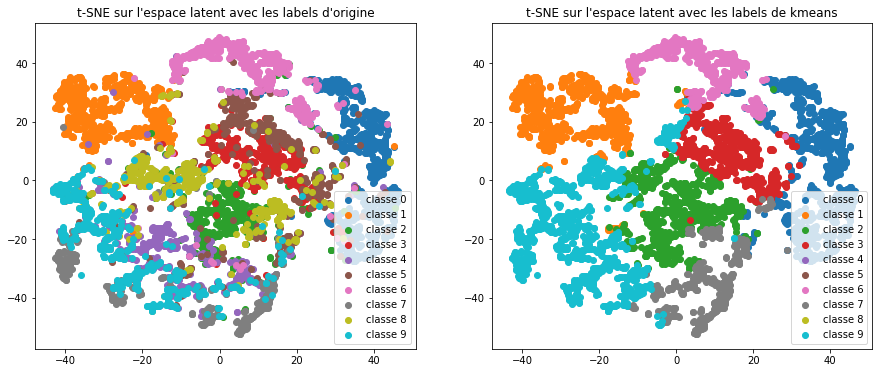

In [19]:
kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(latent_repre)
yhat = kmeans.labels_

latent_repr = auto_encodeur_optimal_rand.encode(X_train)
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
latent_repre_tsne = tsne.fit_transform(latent_repr)

colors = {i: plt.cm.tab10(i) for i in range(10)}

fig = plt.figure(figsize=(15,6))

plt.subplot(121)

for c in range(10):
    plt.scatter(latent_repre_tsne[:,0][Y_train == c],latent_repre_tsne[:,1][Y_train == c],color=colors[c],label=f"classe {c}")
    
plt.title("t-SNE sur l'espace latent avec les labels d'origine")
plt.legend()
plt.subplot(122)

y_cluster_pred = np.zeros(len(latent_repr))
indices = np.arange(len(latent_repr))

for cluster in range(10):

    vals, counts = np.unique(Y_train[yhat == cluster], return_counts=True)
    val_maj = vals[np.argmax(counts)]
    
    y_cluster_pred[indices[yhat == cluster]] = val_maj
    
    
colors = {i: plt.cm.tab10(i) for i in range(10)}
for c in range(10):
    plt.scatter(latent_repre_tsne[:,0][y_cluster_pred == c],latent_repre_tsne[:,1][y_cluster_pred == c],color=colors[c],label=f"classe {c}")
    
plt.title("t-SNE sur l'espace latent avec les labels de kmeans")
plt.legend()
    
plt.show()

- Test

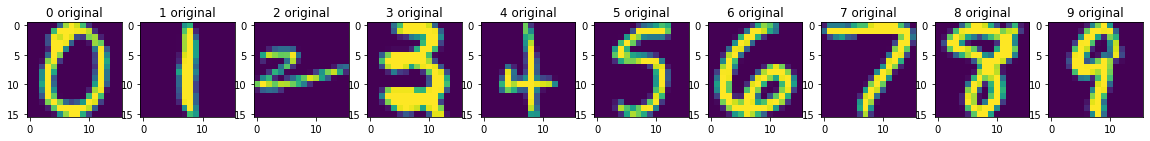

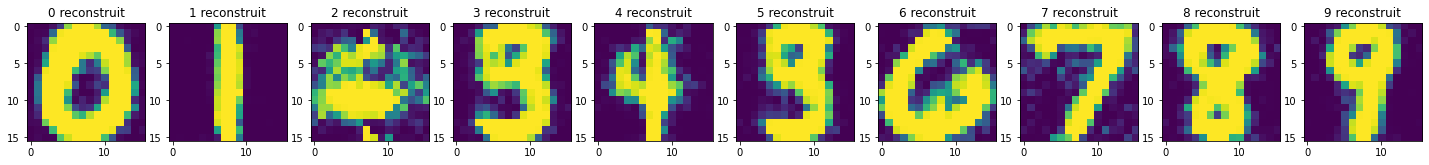

In [20]:
latent_repre_test = auto_encodeur_optimal_rand.encode(X_test)
X_test_hat = auto_encodeur_optimal_rand.decode(latent_repre_test)


plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_test[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_test_hat[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

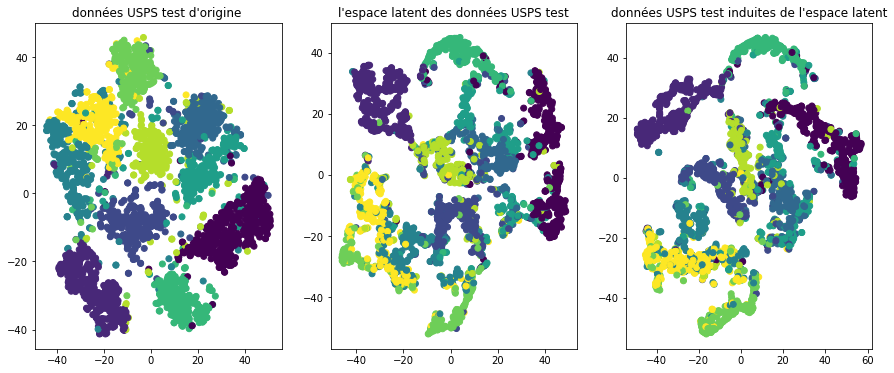

In [21]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


fig = plt.figure(figsize=(15,6))


plt.subplot(131)
repre_2D = tsne.fit_transform(X_test)
plt.title("données USPS test d'origine ")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)

plt.subplot(132)
repre_2D = tsne.fit_transform(latent_repre_test)
plt.title("l'espace latent des données USPS test")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)

plt.subplot(133)
repre_2D = tsne.fit_transform(X_test_hat)
plt.title("données USPS test induites de l'espace latent")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)


plt.show()

### Evaluation de l'espace latent sur un reseau de neurones multi-classe

- Train

In [22]:
datas = [X_train,latent_repre,X_train_hat]
evaluation(datas,Y_train,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:19<00:00,  2.51it/s]


Accuracy sur les images issues de l'auto encodeur 0.9945416599775245
Pureté du clustering :  0.30325895007224274
Rand score  :  0.4087318489675728
Adjusted Rand Score :  0.06473570192554079

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 38.70it/s]


Accuracy sur les images issues de l'auto encodeur 0.691764328142559
Pureté du clustering :  0.4026328463637823
Rand score  :  0.5966058545022128
Adjusted Rand Score :  0.15440074493551928

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:19<00:00,  2.52it/s]


Accuracy sur les images issues de l'auto encodeur 0.8950072242735592
Pureté du clustering :  0.2949109006261037
Rand score  :  0.4292577975291778
Adjusted Rand Score :  0.06833288127541266



([0.9945416599775245, 0.691764328142559, 0.8950072242735592],
 [0.30325895007224274, 0.4026328463637823, 0.2949109006261037],
 [0.4087318489675728, 0.5966058545022128, 0.4292577975291778])

- Test

In [23]:
datas = [X_test,latent_repre_test,X_test_hat]
evaluation(datas,Y_test,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.49it/s]


Accuracy sur les images issues de l'auto encodeur 0.9934832192896709
Pureté du clustering :  0.4209840338872597
Rand score  :  0.6225566851592002
Adjusted Rand Score :  0.17407999831503468

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 77.40it/s]


Accuracy sur les images issues de l'auto encodeur 0.5777126099706745
Pureté du clustering :  0.24796350602802217
Rand score  :  0.40555595913715103
Adjusted Rand Score :  0.050278494610384535

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.89it/s]


Accuracy sur les images issues de l'auto encodeur 0.8813945910720105
Pureté du clustering :  0.2701205604431411
Rand score  :  0.39323652472914367
Adjusted Rand Score :  0.05223320437538349



([0.9934832192896709, 0.5777126099706745, 0.8813945910720105],
 [0.4209840338872597, 0.24796350602802217, 0.2701205604431411],
 [0.6225566851592002, 0.40555595913715103, 0.39323652472914367])

### PCA sur l'espace latent appris par reseau

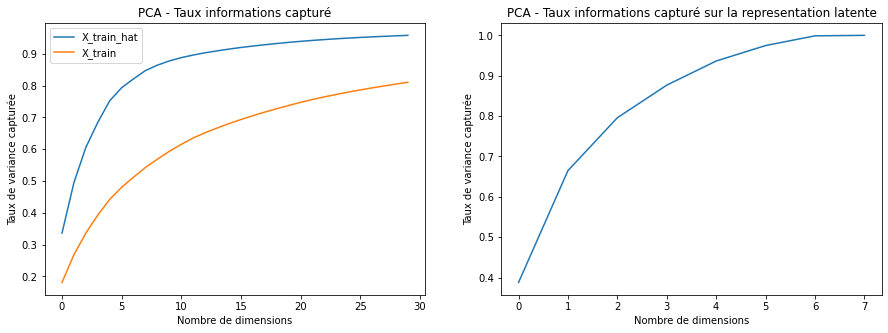

La quantité d'information moyenne perdue pendant le decodage :  0.02902419221680825


In [24]:
pca_1 = PCA(n_components=30,random_state=96)
pca_1.fit(X_train_hat)

pca_2 = PCA(n_components=30,random_state=96)
pca_2.fit(X_train)

pca_3 = PCA(n_components=dim_latent_optimale,random_state=96)
pca_3.fit(latent_repre)


plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.legend(["X_train_hat","X_train"])
plt.title("PCA - Taux informations capturé")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")


plt.subplot(122)
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.title("PCA - Taux informations capturé sur la representation latente")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")

plt.show()

quantite_info_apres_decodage = pca_1.explained_variance_ratio_[:8]
quantite_info_espace_latent = pca_3.explained_variance_ratio_
print("La quantité d'information moyenne perdue pendant le decodage : ",
      np.abs( quantite_info_apres_decodage - quantite_info_espace_latent ).mean())

- Le taux d'informations capturé sur la representation latente converge vers un taux de 100% au bout de 6 dimensions . 
- On remarque aussi que le taux d'informations augmente plutot rapidement au fil des dimensions , ce qui veut dire que l'encodage de l'information est plutot pas mal.
- Conclusion : la dimension ideale d'arrivée de l'encodeur peut etre fixé à 6 .


- Le taux d'informations recuperé sur les données issues de l'espace latent augmente plus rapidement par rapport à celles des données de l'espace d'origine.  
- Le taux d'informations recuperé sur les données issues de l'espace latent arrivé à 100% au bout de 30 dimensions contrairement à celles des données de l'espace d'origine qui arrve uniquement à 80% de l'informations.
- la difference de la quantité d'informations recuperés dans l'espace latent et celle du decodage de cet espace doit etre minimale pour pouvoir dire que le decodage a pu garder l'information de l'espace latent ( l'information de l'espace d'origine reduites en dimension )  
- Un bon espace latent (regroupant le max d'informations de l'espace d'origine) permet de decoder de nouvelles images avec un pattern de chiffre parfait ( prend en compte le pattern de tous les chiffres de la classe y compris les images bruités).
- les données USPS d'origine présentent une quantité de bruit et de la redondance, ce qui peut brouiller la structure sous-jacente des données. Dans ce cas, la compression de dimension (l'encodage) aide à éliminer une partie du bruit et de la redondance, ce qui peut conduire à une PCA de meilleure qualité pour la représentation de dimension réduite.

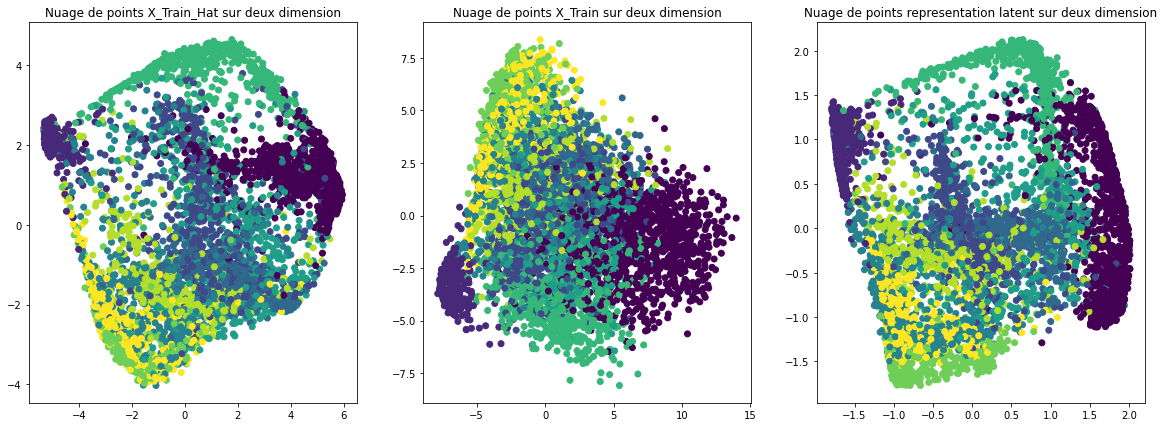

In [25]:
X_train_hat_pca = pca_1.transform(X_train_hat)
X_train_pca = pca_2.transform(X_train)
latent_repre_pca = pca_3.transform(latent_repre)

plt.figure(figsize=(20,7))

plt.subplot(131)
plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],c=Y_train)
plt.title("Nuage de points X_Train_Hat sur deux dimension")

plt.subplot(132)
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=Y_train)
plt.title("Nuage de points X_Train sur deux dimension")

plt.subplot(133)
plt.scatter(latent_repre_pca[:,0],latent_repre_pca[:,1],c=Y_train)
plt.title("Nuage de points representation latent sur deux dimension")


plt.show()

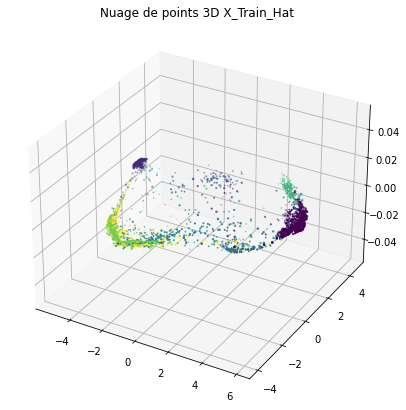

In [26]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D X_Train_Hat")
plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],X_train_hat_pca[:,2],c=Y_train)
plt.show()

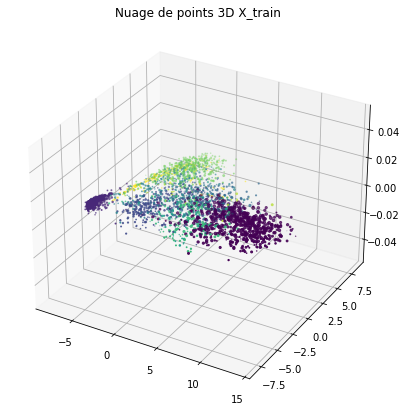

In [27]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D X_train")
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],X_train_pca[:,2],c=Y_train)
plt.show()

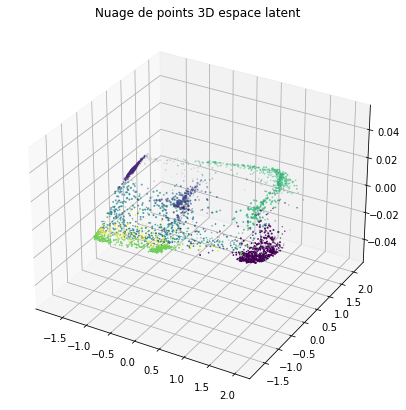

In [28]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D espace latent")
plt.scatter(latent_repre_pca[:,0],latent_repre_pca[:,1],latent_repre_pca[:,2],c=Y_train)
plt.show()

### Impact du batch sur l'apprentissage de l'espace latent

In [29]:
shape = X_train.shape[1]
nb_layers = nb_layer_optimal
output_dim = dim_latent_optimale

size = len(auto_encodeur_optimal_rand.layers_encodeur)
auto_encodeur_optimal_rand.layers_encodeur = np.array(auto_encodeur_optimal_rand.layers_encodeur)
indices = [i for i in range(size) if i % 2 == 1 ]
activ_enc = auto_encodeur_optimal_rand.layers_encodeur[indices]

auto_encodeur_optimal_rand.layers_decodeur = np.array(auto_encodeur_optimal_rand.layers_decodeur)
indices = [i for i in range(size) if i % 2 == 1 ]
activ_dec = list(auto_encodeur_optimal_rand.layers_decodeur[indices])

activations = [ activ_enc , activ_dec]

facteur_norma = 0.8
plage_biais = (0,1)
epochs = 50
liste_batch_size = [50,300,500]
liste_auto_encodeurs = []

for batch_size in liste_batch_size:

    liste_auto_encodeurs.append(create_auto_encodeur(X_train,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4))

100%|███████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


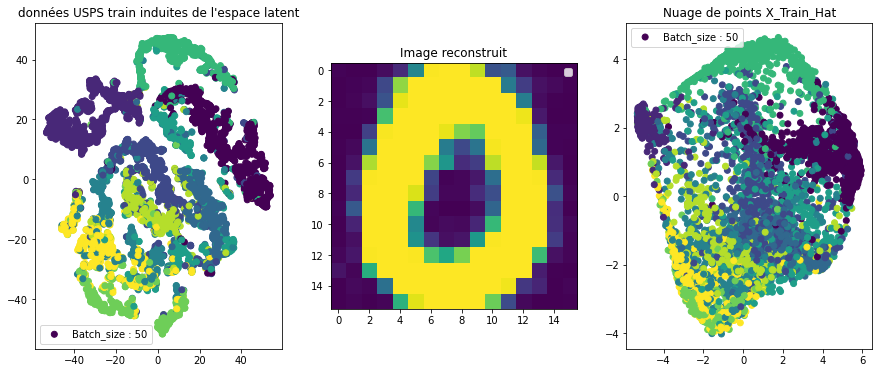

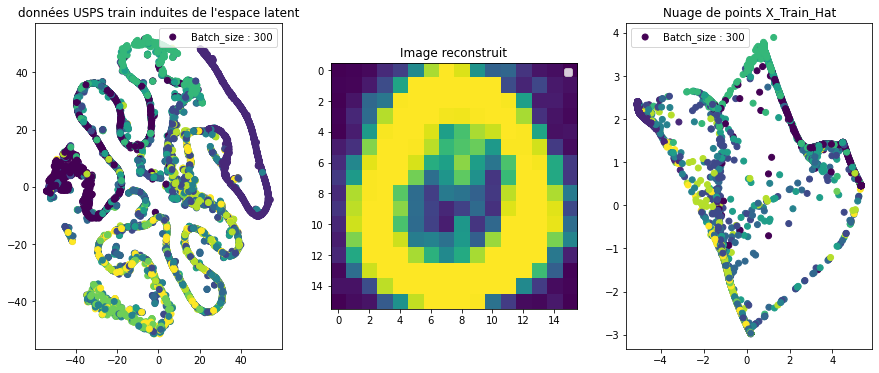

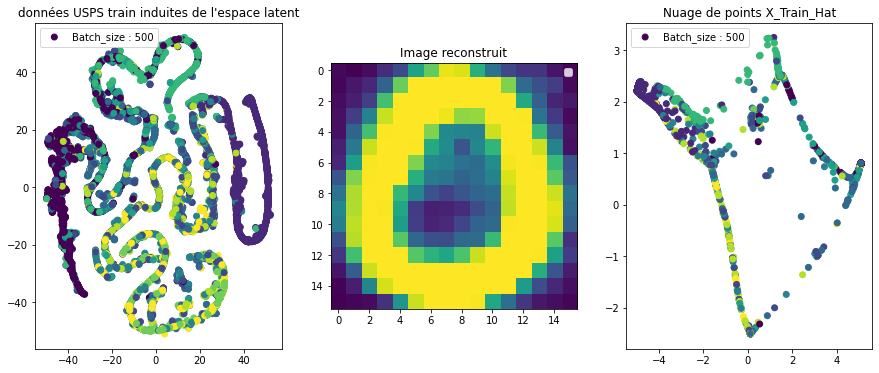

In [30]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)

for i,auto_encodeur in enumerate(liste_auto_encodeurs):
    
    latent_repre = auto_encodeur.encode(X_train)
    X_train_hat = auto_encodeur.decode(latent_repre)
    
    X_train_hat_pca = pca_1.transform(X_train_hat)
    

    fig = plt.figure(figsize=(15,6))


    plt.subplot(1,3,1)
    repre_2D = tsne.fit_transform(X_train_hat)
    plt.title("données USPS train induites de l'espace latent")
    plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    plt.subplot(1,3,2)
    plt.title("Image reconstruit")
    image = X_train_hat[Y_train == 0][27].reshape((16,16))
    plt.imshow(image)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    
    plt.subplot(1,3,3)
    plt.title("Nuage de points X_Train_Hat")
    plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],c=Y_train)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    plt.show()

## Debruitage de données

#### Bruit poisson

100%|███████████████████████████████████████████| 50/50 [00:23<00:00,  2.11it/s]


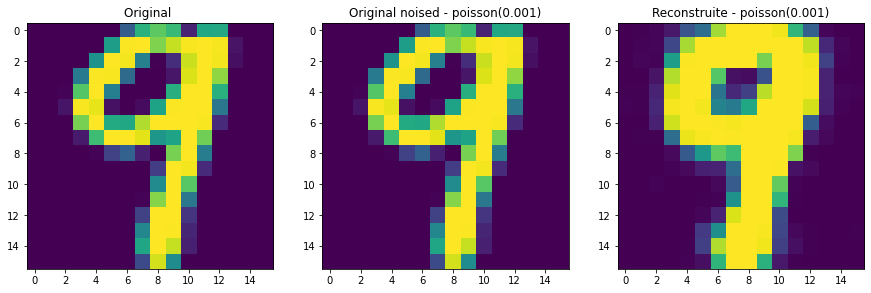

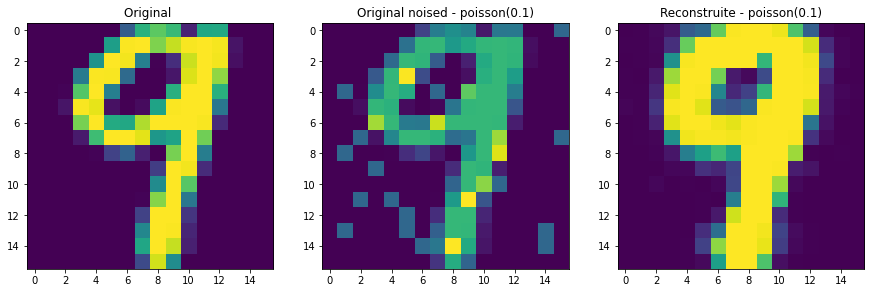

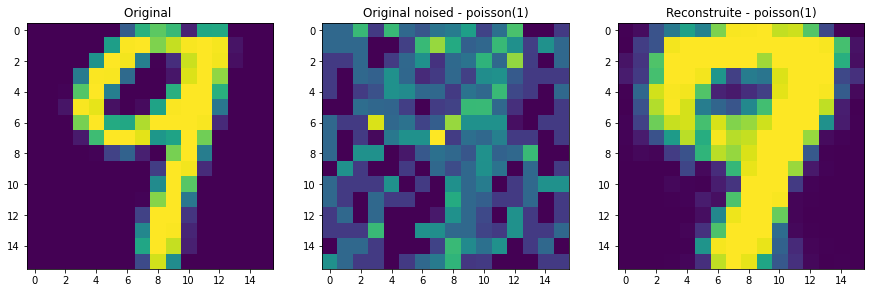

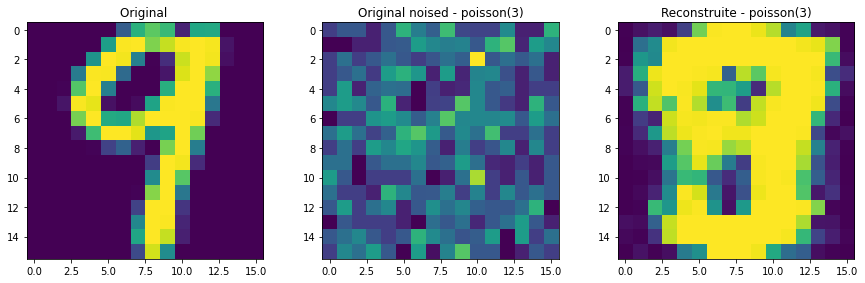

In [31]:
lamdas = [1e-3,1e-1,1,3]
scores = []

for i,lamda in enumerate(lamdas):
    noise = generate_noise(X_train.shape[1],'poisson',lamda,1e-1)
    X_train_noised = X_train + noise
    
    latent_repre_noised = auto_encodeur_optimal_rand.encode(X_train_noised)
    X_train_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)
    sample = 1
    plt.figure(figsize=(15,20))

    plt.subplot(i+1,3,1)
    plt.title("Original ")
    image = X_train[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,2)
    plt.title("Original noised - poisson("+str(lamda)+")")
    image = X_train_noised[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,3)
    plt.title("Reconstruite - poisson("+str(lamda)+")")
    image = X_train_noised_hat[sample].reshape((16,16))
    plt.imshow(image)
    
    datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
    scores.append(evaluation(datas,Y_train,verbose=False)[0][2])
    
plt.show()

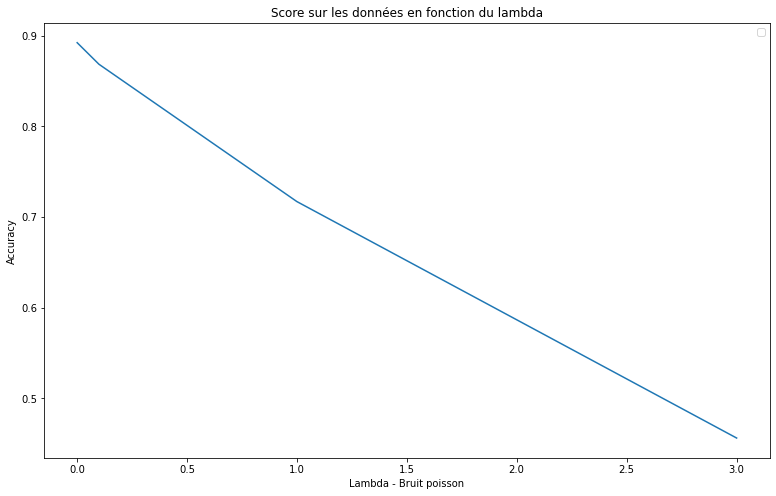

In [32]:
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du lambda")
plt.xlabel("Lambda - Bruit poisson")
plt.ylabel("Accuracy")
plt.legend(["Train"])
plt.plot(lamdas,scores)
plt.show()

In [33]:
#### Bruit gaussien

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.39it/s]


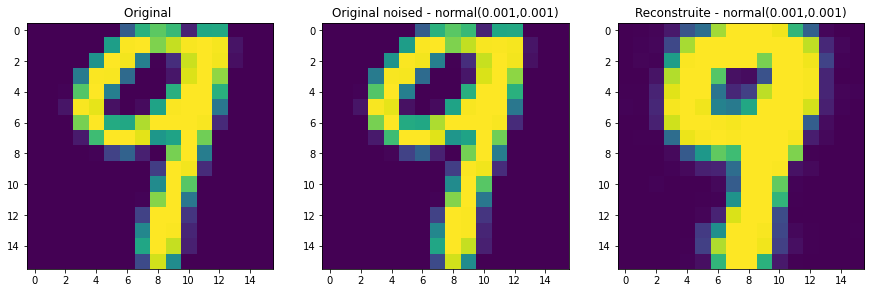

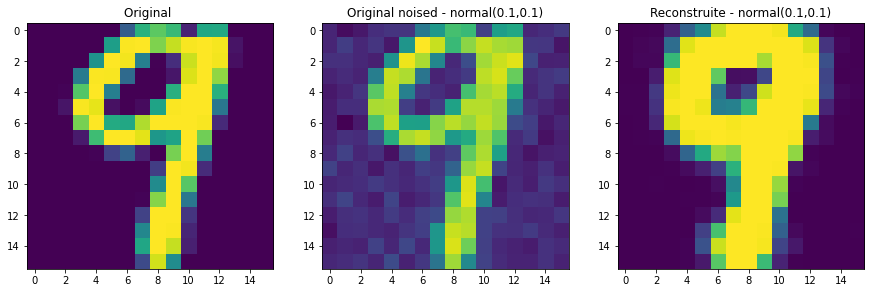

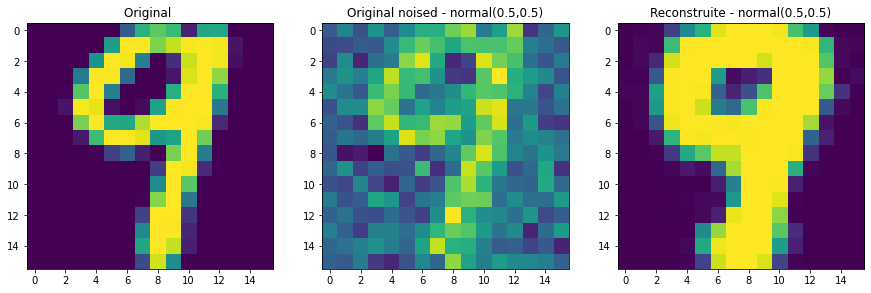

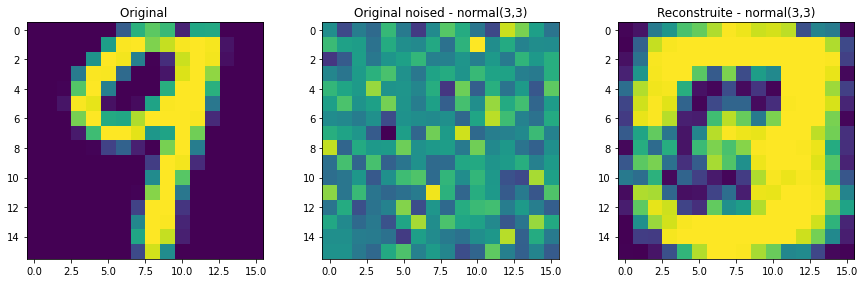

In [34]:
means = [1e-3,1e-1,0.5,3]
stds = [1e-3,1e-1,0.5,3]
scores = []


for i,mean in enumerate(means):
    noise = generate_noise(X_train.shape[1],'gaussien',mean,stds[i])
    X_train_noised = X_train + noise
    
    latent_repre_noised = auto_encodeur_optimal_rand.encode(X_train_noised)
    X_train_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)
    sample = 1
    plt.figure(figsize=(15,20))

    plt.subplot(i+1,3,1)
    plt.title("Original ")
    image = X_train[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,2)
    plt.title("Original noised - normal("+str(mean)+","+str(stds[i])+")")
    image = X_train_noised[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,3)
    plt.title("Reconstruite - normal("+str(mean)+","+str(stds[i])+")")
    image = X_train_noised_hat[sample].reshape((16,16))
    plt.imshow(image)
    
    datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
    scores.append(evaluation(datas,Y_train,verbose=False)[0][2])
    
    
plt.show()

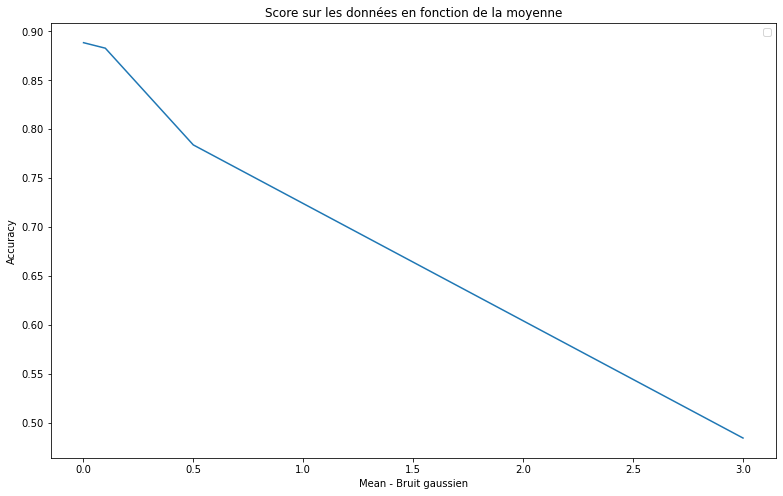

In [35]:
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction de la moyenne")
plt.xlabel("Mean - Bruit gaussien")
plt.ylabel("Accuracy")
plt.legend(["Train"])
plt.plot(means,scores)
plt.show()

- Train

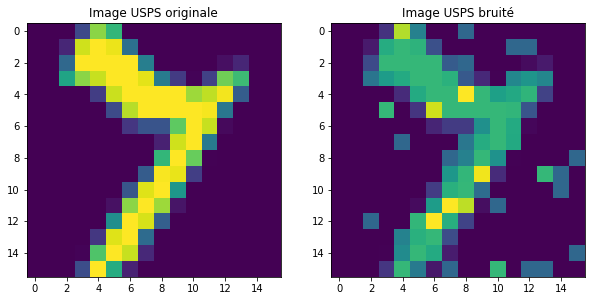

In [36]:
noise = generate_noise(X_train.shape[1],'poisson',1e-1,1e-1)
X_train_noised = X_train + noise

plt.figure(figsize=(10,6))

plt.subplot(121)
plt.title("Image USPS originale")
plt.imshow(X_train[10].reshape((16,16)))

plt.subplot(122)
plt.title("Image USPS bruité")
plt.imshow(X_train_noised[10].reshape((16,16)))
plt.show()

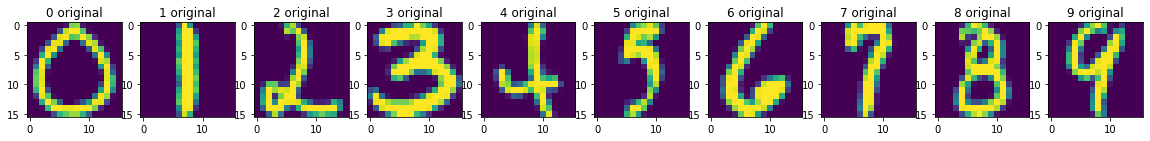

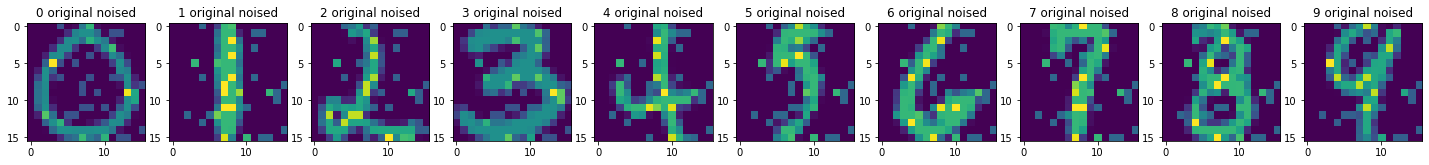

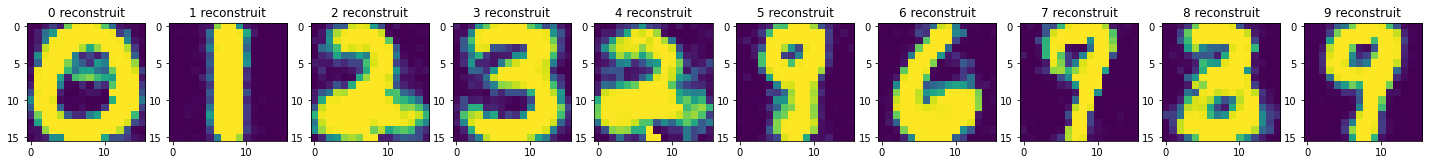

In [37]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,50)

latent_repre_noised = auto_encodeur_optimal_rand.encode(X_train_noised)
X_train_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original noised")
    image = X_train_noised[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_noised_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

In [38]:
datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
evaluation(datas,Y_train,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


Accuracy sur les images issues de l'auto encodeur 0.9930968052656928
Pureté du clustering :  0.30325895007224274
Rand score  :  0.4087318489675728
Adjusted Rand Score :  0.06473570192554079

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 35.14it/s]


Accuracy sur les images issues de l'auto encodeur 0.6954567346283512
Pureté du clustering :  0.37646492213838495
Rand score  :  0.5430243047596894
Adjusted Rand Score :  0.11876004353883764

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:21<00:00,  2.30it/s]


Accuracy sur les images issues de l'auto encodeur 0.8693209182854391
Pureté du clustering :  0.37582276448868196
Rand score  :  0.5505284654319051
Adjusted Rand Score :  0.1438898543181409



([0.9930968052656928, 0.6954567346283512, 0.8693209182854391],
 [0.30325895007224274, 0.37646492213838495, 0.37582276448868196],
 [0.4087318489675728, 0.5430243047596894, 0.5505284654319051])

- Test

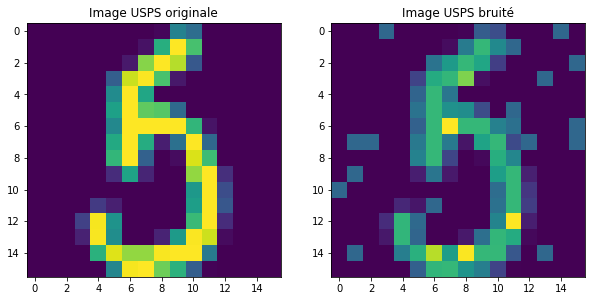

In [53]:
noise = generate_noise(X_test.shape[1],'poisson',1e-1,1e-1)
X_test_noised = X_test + noise

plt.figure(figsize=(10,6))

plt.subplot(121)
plt.title("Image USPS originale")
plt.imshow(X_test[10].reshape((16,16)))

plt.subplot(122)
plt.title("Image USPS bruité")
plt.imshow(X_test_noised[10].reshape((16,16)))
plt.show()

In [54]:
latent_repre_noised = auto_encodeur_optimal_rand.encode(X_test_noised)
X_test_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)

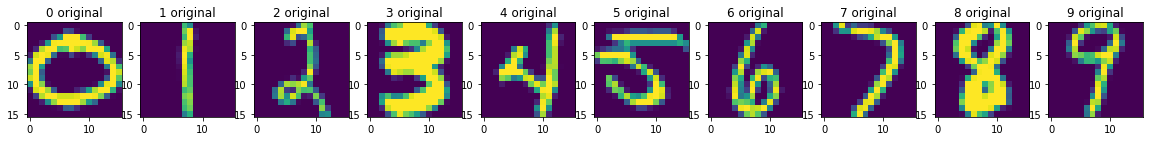

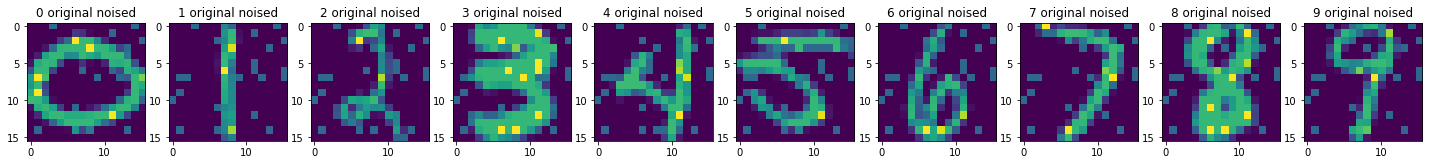

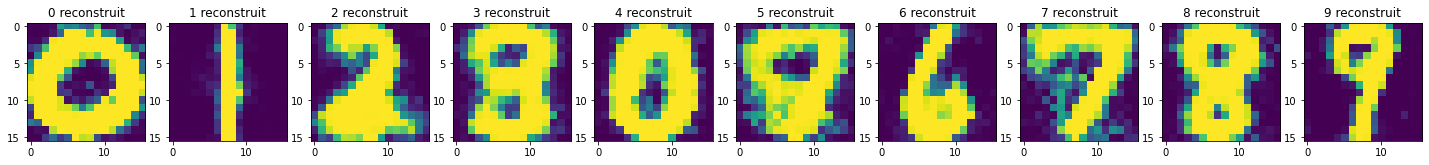

In [55]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,50)

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_test[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original noised")
    image = X_test_noised[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_test_noised_hat[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

In [56]:
datas = [X_test_noised,latent_repre_noised,X_test_noised_hat]
evaluation(datas,Y_test,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.79it/s]


Accuracy sur les images issues de l'auto encodeur 0.9912023460410557
Pureté du clustering :  0.4209840338872597
Rand score  :  0.6225566851592002
Adjusted Rand Score :  0.17407999831503468

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 76.34it/s]


Accuracy sur les images issues de l'auto encodeur 0.5871619420006516
Pureté du clustering :  0.33235581622678395
Rand score  :  0.4643125539790384
Adjusted Rand Score :  0.0944704497752477

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.09it/s]


Accuracy sur les images issues de l'auto encodeur 0.8813945910720105
Pureté du clustering :  0.2821766047572499
Rand score  :  0.3767126197415973
Adjusted Rand Score :  0.055676785873618004



([0.9912023460410557, 0.5871619420006516, 0.8813945910720105],
 [0.4209840338872597, 0.33235581622678395, 0.2821766047572499],
 [0.6225566851592002, 0.4643125539790384, 0.3767126197415973])

# 2. Données Wine

In [43]:
from sklearn.datasets import load_wine
data = load_wine()
labels = data.target

wine_data_norm = normalisation(data.data)

In [44]:
output_dim = 3
nb_layers = 2
TanH = ModuleTanH()
sig = ModuleSigmoide()
activ_enc = [TanH for _ in range(2)]
activ_dec = [TanH for _ in range(1)]
activ_dec.append(sig)

activations = [activ_enc , activ_dec]

facteur_norma = 0.8
plage_biais = (0,1)
batch_size = 50
epochs = 100


wine_auto_encodeur = create_auto_encodeur(wine_data_norm,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)


net_to_graph(wine_auto_encodeur.network, net_name="networks_images/network_AE_wine", horizontal=True)


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 657.58it/s]


Accuracy sur l'espace d'origine :  0.9887640449438202
Puerete du clustering sur l'espace d'origine:  0.949438202247191

Accuracy sur l'espace latent :  0.8595505617977528
Puerete du clustering sur l'espace latent :  0.7808988764044944


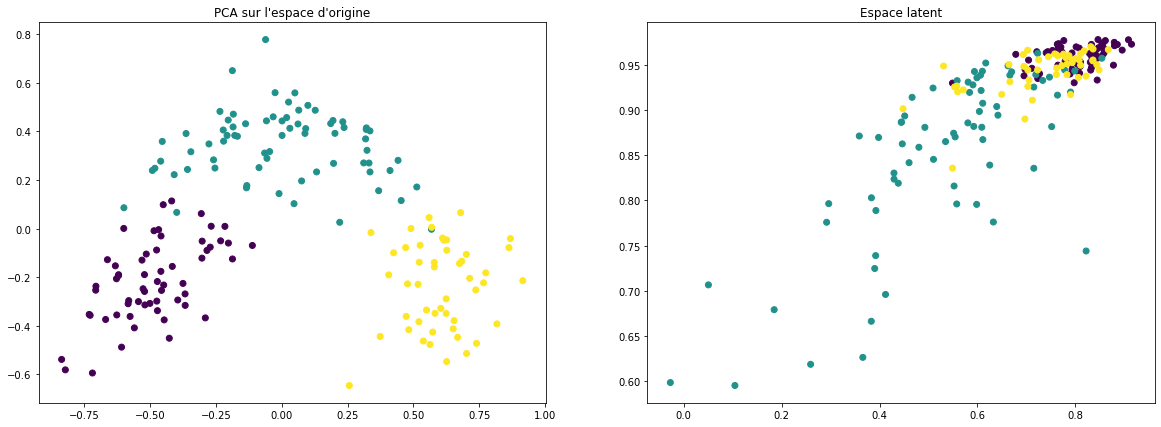

In [45]:
plt.figure(figsize=(20,7))

pca = PCA(n_components=2,random_state=96)
pca.fit(wine_data_norm)
wine_data_norm_pca = pca.transform(wine_data_norm)

plt.subplot(121)
plt.title("PCA sur l'espace d'origine")
plt.scatter(wine_data_norm_pca[:,0],wine_data_norm_pca[:,1],c=labels)

latent_repre = wine_auto_encodeur.encode(wine_data_norm)
plt.subplot(122)
plt.title("Espace latent")
plt.scatter(latent_repre[:,0],latent_repre[:,1],c=labels)


latent_repre = wine_auto_encodeur.encode(wine_data_norm)


clf = LogisticRegression(random_state=0).fit(wine_data_norm,labels)
print("Accuracy sur l'espace d'origine : ",clf.score(wine_data_norm,labels))
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=100).fit(wine_data_norm)
yhat = kmeans.labels_

print("Puerete du clustering sur l'espace d'origine: ",cluster_purity(yhat,labels))
print()

clf = LogisticRegression(random_state=0).fit(latent_repre,labels)
print("Accuracy sur l'espace latent : ",clf.score(latent_repre,labels))
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=100).fit(latent_repre)
yhat = kmeans.labels_

print("Puerete du clustering sur l'espace latent : ",cluster_purity(yhat,labels))

# 3. Données Crédit Card

In [46]:
cc_data = pd.read_csv("data/CC GENERAL.csv")

In [47]:
cc_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [48]:
# supprimer les valeurs NaN
cc_data = cc_data.dropna()

cc_data = np.array(cc_data)
# supprimer la colonne 1
cc_data = cc_data[:,1:]
cc_data = cc_data.astype('float')
y = np.random.randint(0,1,cc_data.shape[0])

data_norm = normalisation(cc_data)

data_norm = data_norm.astype('float')

In [49]:
shape = data_norm.shape[1]
nb_layers = 2
output_dim = 7

TanH = ModuleTanH()
sig = ModuleSigmoide()
activ_enc = [TanH for _ in range(nb_layers)]
activ_dec = [TanH for _ in range(nb_layers - 1)]
activ_dec.append(sig)

activations = [activ_enc , activ_dec]


facteur_norma = 0.8
plage_biais = (0,1)
batch_size = 50
epochs = 50

auto_encodeur_cc_optimal= create_auto_encodeur(data_norm,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)

net_to_graph(auto_encodeur_cc_optimal.network, net_name="networks_images/network_AE_credit_card", horizontal=True)



100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.52it/s]


In [50]:
latent_repre = auto_encodeur_cc_optimal.encode(data_norm)
data_norm_hat = auto_encodeur_cc_optimal.decode(latent_repre)

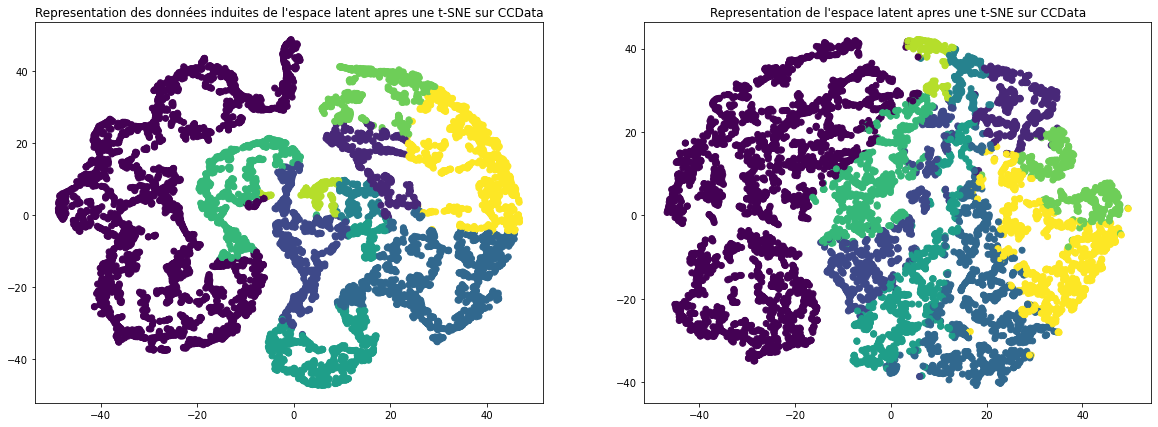

In [51]:
kmeans = KMeans(n_clusters=10, random_state=0, max_iter=100).fit(data_norm_hat)

plt.figure(figsize=(20,7))

yhat = kmeans.labels_

plt.subplot(121)
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(data_norm_hat)

plt.title("Representation des données induites de l'espace latent apres une t-SNE sur CCData")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=yhat)

plt.subplot(122)
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(latent_repre)

plt.title("Representation de l'espace latent apres une t-SNE sur CCData")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=yhat)

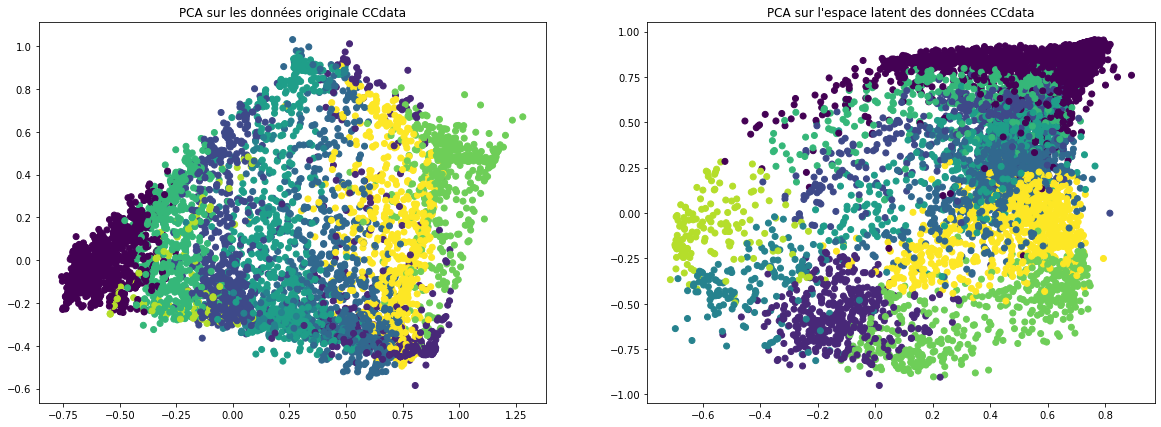

In [52]:
pca = PCA(n_components=17,random_state=96)
pca.fit(data_norm)
X_train_pca = pca.transform(data_norm)


plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=yhat)
plt.title("PCA sur les données originale CCdata")

plt.subplot(1,2,2)
plt.title("PCA sur l'espace latent des données CCdata")
plt.scatter(latent_repre[:,0],latent_repre[:,1],c=yhat)